In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly_express as px
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
data = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(data))
data.head()

544


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
hlp.pandas.numeric_summary(data)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
height,544,0,0.0%,0,0.0%,138.3,27.6,0.2,-1.3,0.6,54.0,91.4,125.1,148.6,157.5,162.6,179.1
weight,544,0,0.0%,0,0.0%,35.6,14.7,0.4,-0.5,-0.9,4.2,12.5,22.0,40.1,47.2,51.6,63.0
age,544,0,0.0%,11,2.0%,29.3,20.8,0.7,0.5,-0.5,0.0,3.0,12.0,27.0,43.0,58.0,88.0
male,544,0,0.0%,287,53.0%,0.5,0.5,1.1,0.1,-2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [43]:
px.scatter(
    data,
    x='weight',
    y='height',
    color=data['male'].apply(lambda x: 'male' if x else 'female'),
    trendline='lowess',
    labels={'color': 'Sex'},
    title="Weight vs Height<br><sup>by Sex</sup>"
)

In [47]:
px.histogram(
    data,
    x='height',
    color=data['male'].apply(lambda x: 'male' if x else 'female'),
    labels={'color': 'Sex'},
    title="Height"
)

---

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer

def transform_is_adult(X):
    values = X[['age']].apply(lambda v: 1 if (v >= 18).all() else 0, axis=1).values
    return np.reshape(values, (-1, 1))

pipeline = make_column_transformer(
    (make_pipeline(StandardScaler(), PolynomialFeatures(3, include_bias=False)), ['weight']),
    (FunctionTransformer(func=transform_is_adult), ['age']),
    ('passthrough', ['male']),
)

# pipeline = make_pipeline(
#     StandardScaler(),
#     make_column_transformer((PolynomialFeatures(3, include_bias=False), ['weight']))
# )

X = data.copy().drop(columns='height')
y = data['height']

print(X.head())
X = pipeline.fit_transform(X)
X.shape


      weight   age  male
0  47.825606  63.0     1
1  36.485807  63.0     0
2  31.864838  65.0     0
3  53.041914  41.0     1
4  41.276872  51.0     0


(544, 5)

In [5]:
print(data['age'].iloc[:20])
pd.DataFrame(X).head(20)

0     63.0
1     63.0
2     65.0
3     41.0
4     51.0
5     35.0
6     32.0
7     27.0
8     19.0
9     54.0
10    47.0
11    66.0
12    73.0
13    20.0
14    65.3
15    36.0
16    44.0
17    31.0
18    12.0
19     8.0
Name: age, dtype: float64


,0,1,2,3,4
0,0.830633,0.689951,0.573096,1.0,1.0
1,0.059514,0.003542,0.000211,1.0,0.0
2,-0.254717,0.064881,-0.016526,1.0,0.0
3,1.185347,1.405049,1.665471,1.0,1.0
4,0.385312,0.148465,0.057205,1.0,0.0
5,1.862004,3.467060,6.455681,1.0,1.0
6,0.179037,0.032054,0.005739,1.0,0.0
7,1.351138,1.825574,2.466602,1.0,1.0
8,-0.050371,0.002537,-0.000128,1.0,0.0
9,1.283665,1.647796,2.115218,1.0,1.0


# Model - Poly

In [6]:
import pytensor.tensor as at

with pm.Model() as model_poly:
    # this is so we can update the data to make out of sample predictions
    X_ = pm.MutableData("X", X)
    y_ = pm.MutableData("y", y)

    a = pm.Normal("a", mu=178, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    # b1 = pm.Lognormal("b1", mu=0, sigma=1)
    # b2 = pm.Normal("b2", mu=0, sigma=1)
    # b3 = pm.Normal("b3", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + at.dot(X_, beta))
    #mu = pm.Deterministic("mu", a + b1 * X[:, 0] + b2 * X[:, 1] + b3 * X[:, 2])
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=y_)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, beta, height, sigma]


# Prior Checks

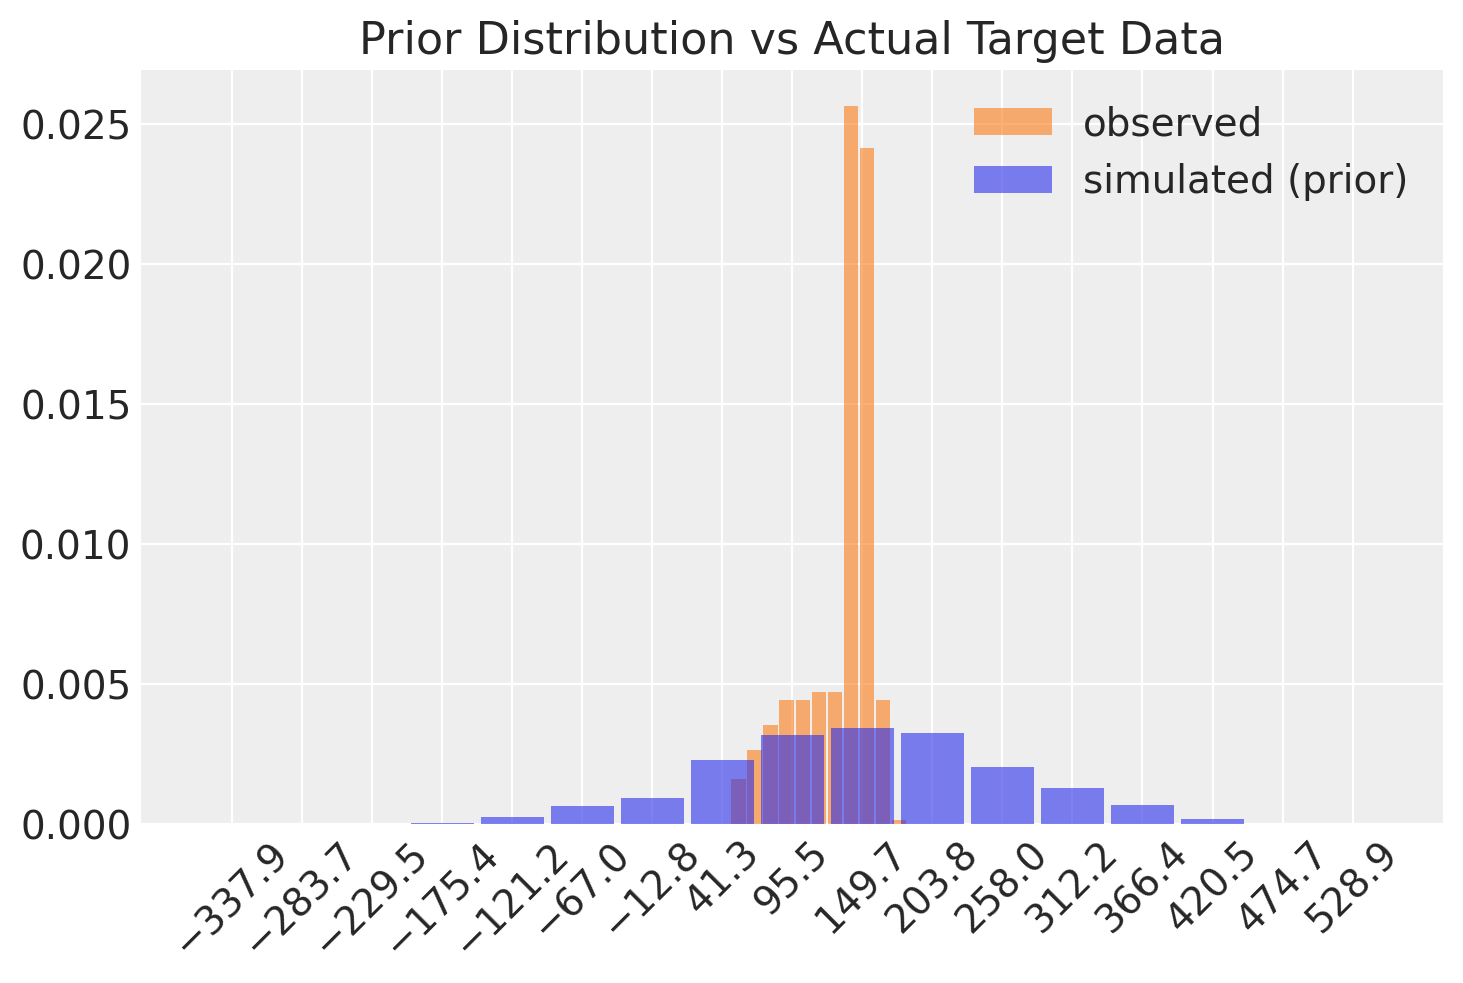

In [7]:
az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (prior)",
)
plt.xticks(rotation=45)
plt.title('Prior Distribution vs Actual Target Data');

# Posterior

In [8]:
with model_poly:
    # Train model
    idata_posterior = pm.sample(draws=1000, tune=1000)
    # Get samples from the posterior (predictions i.e. associated with the observed data)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [height]


## Model Parameters

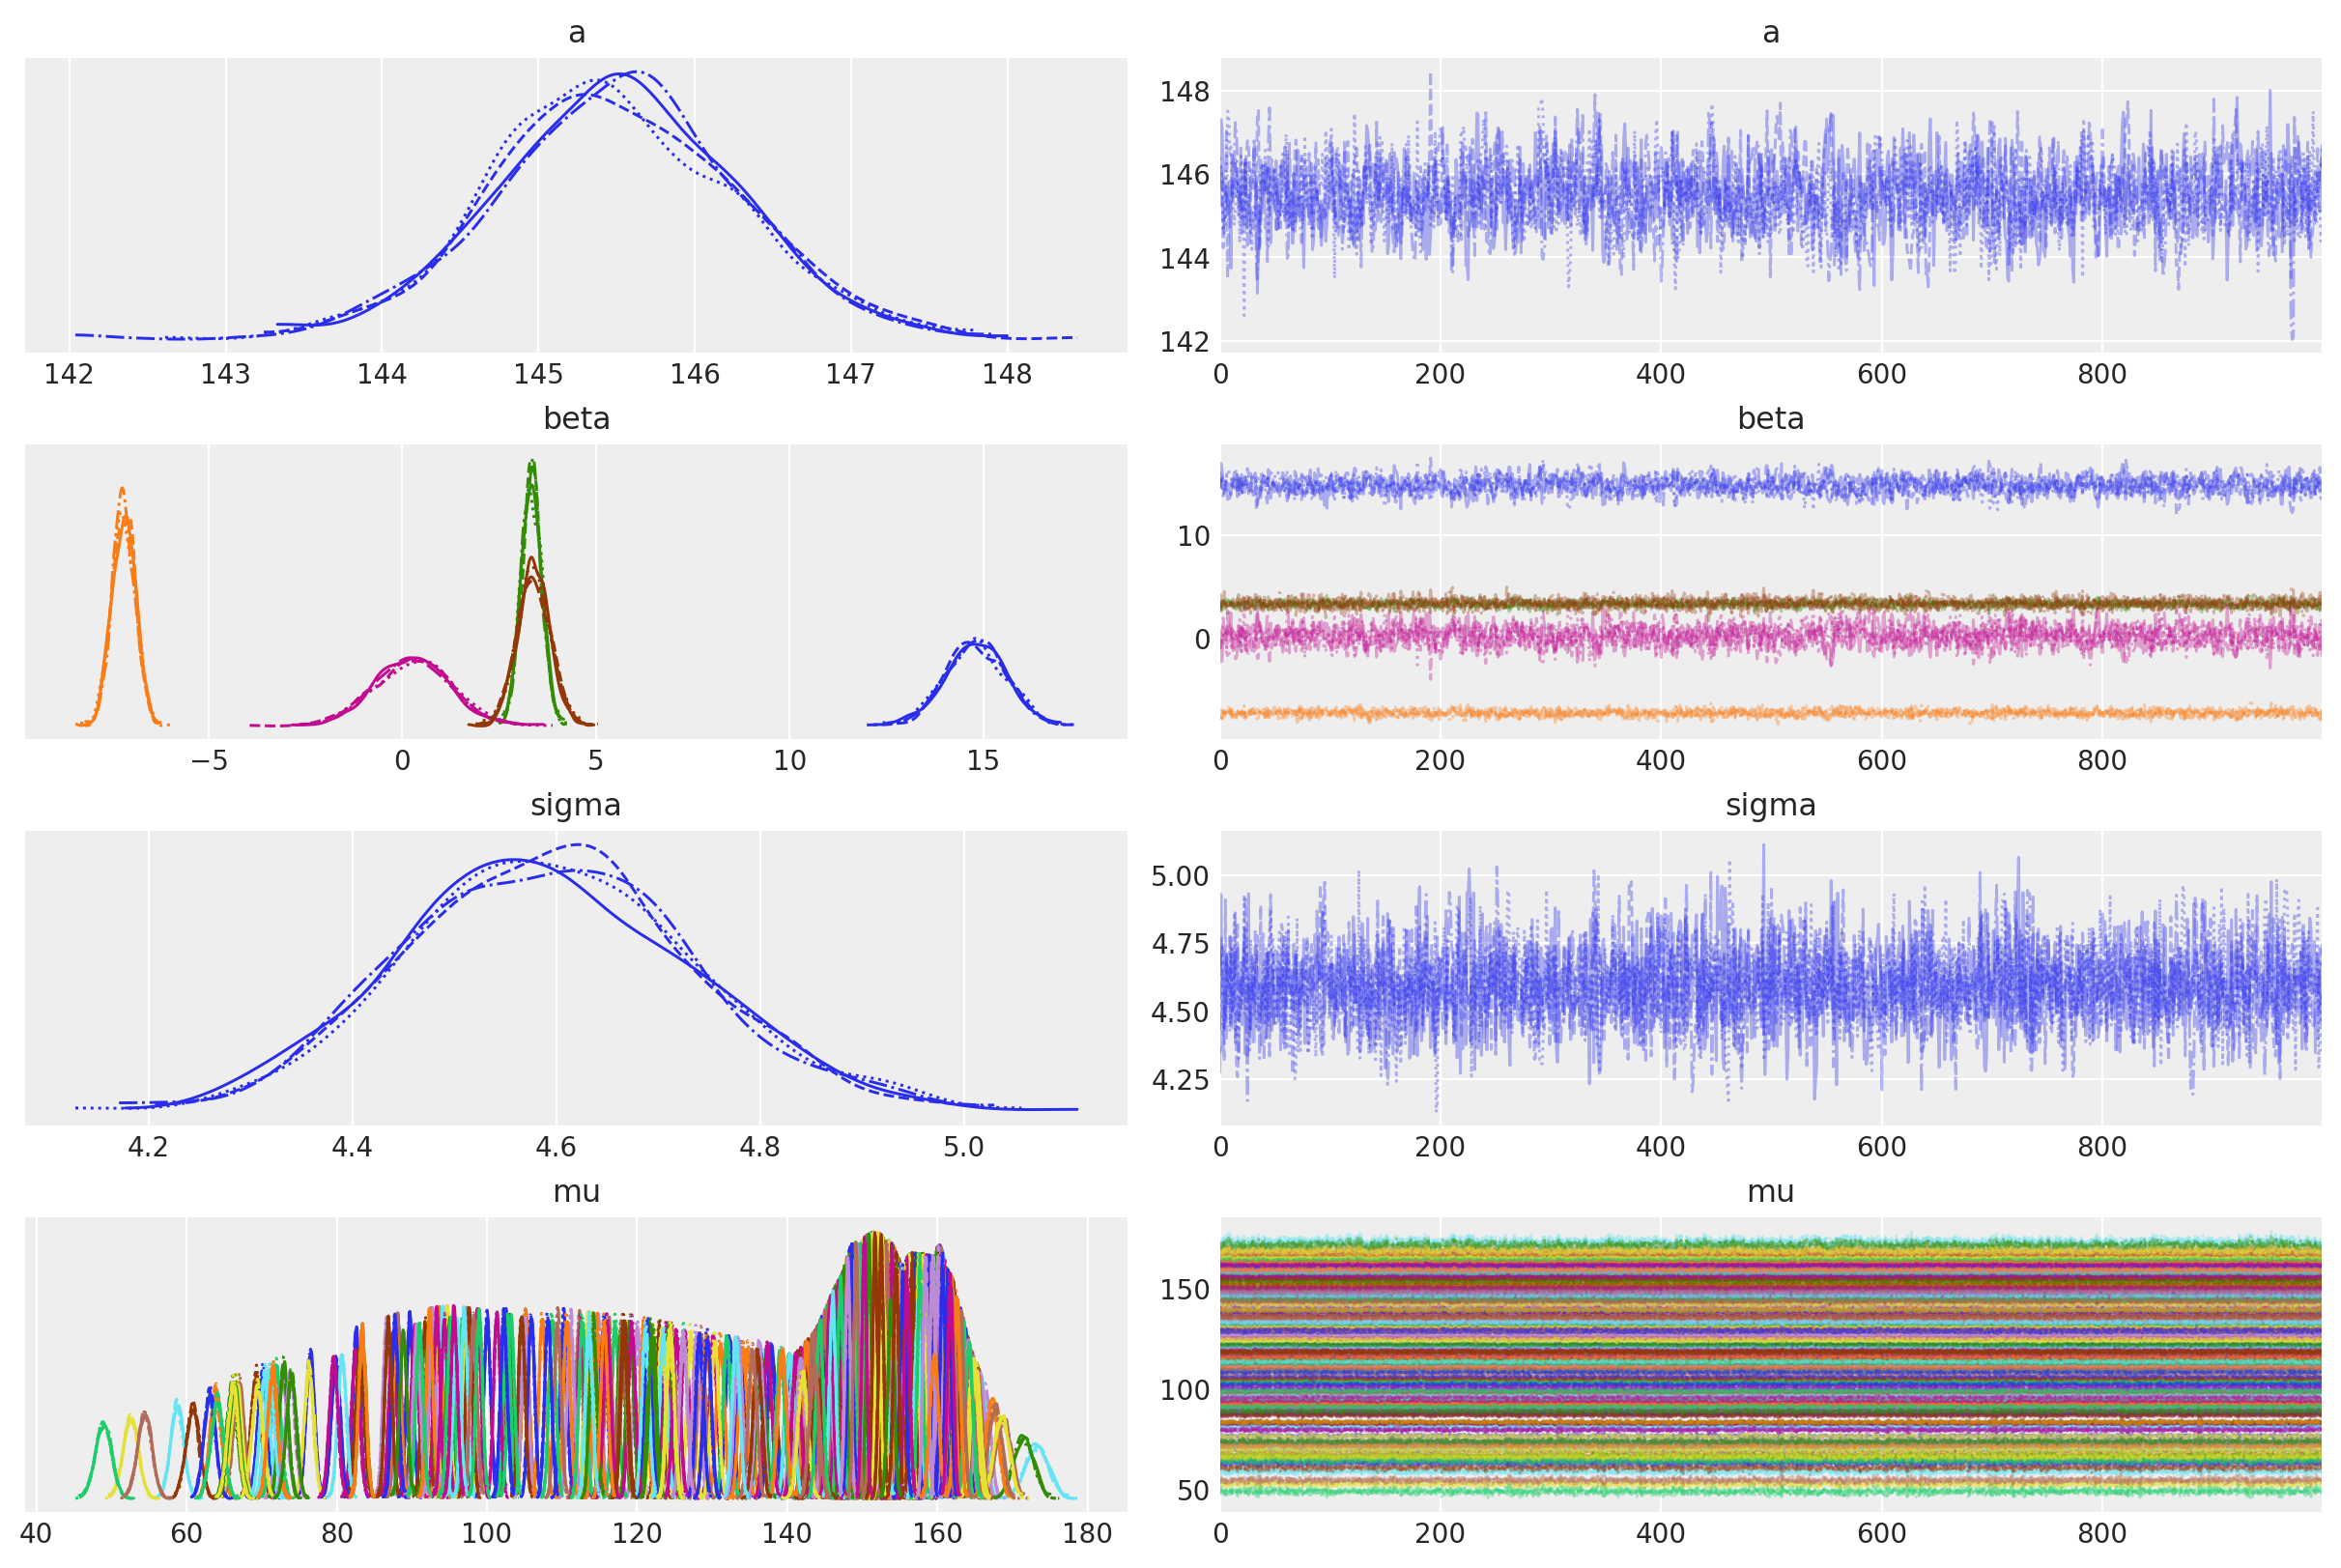

In [9]:
az.plot_trace(idata_posterior);

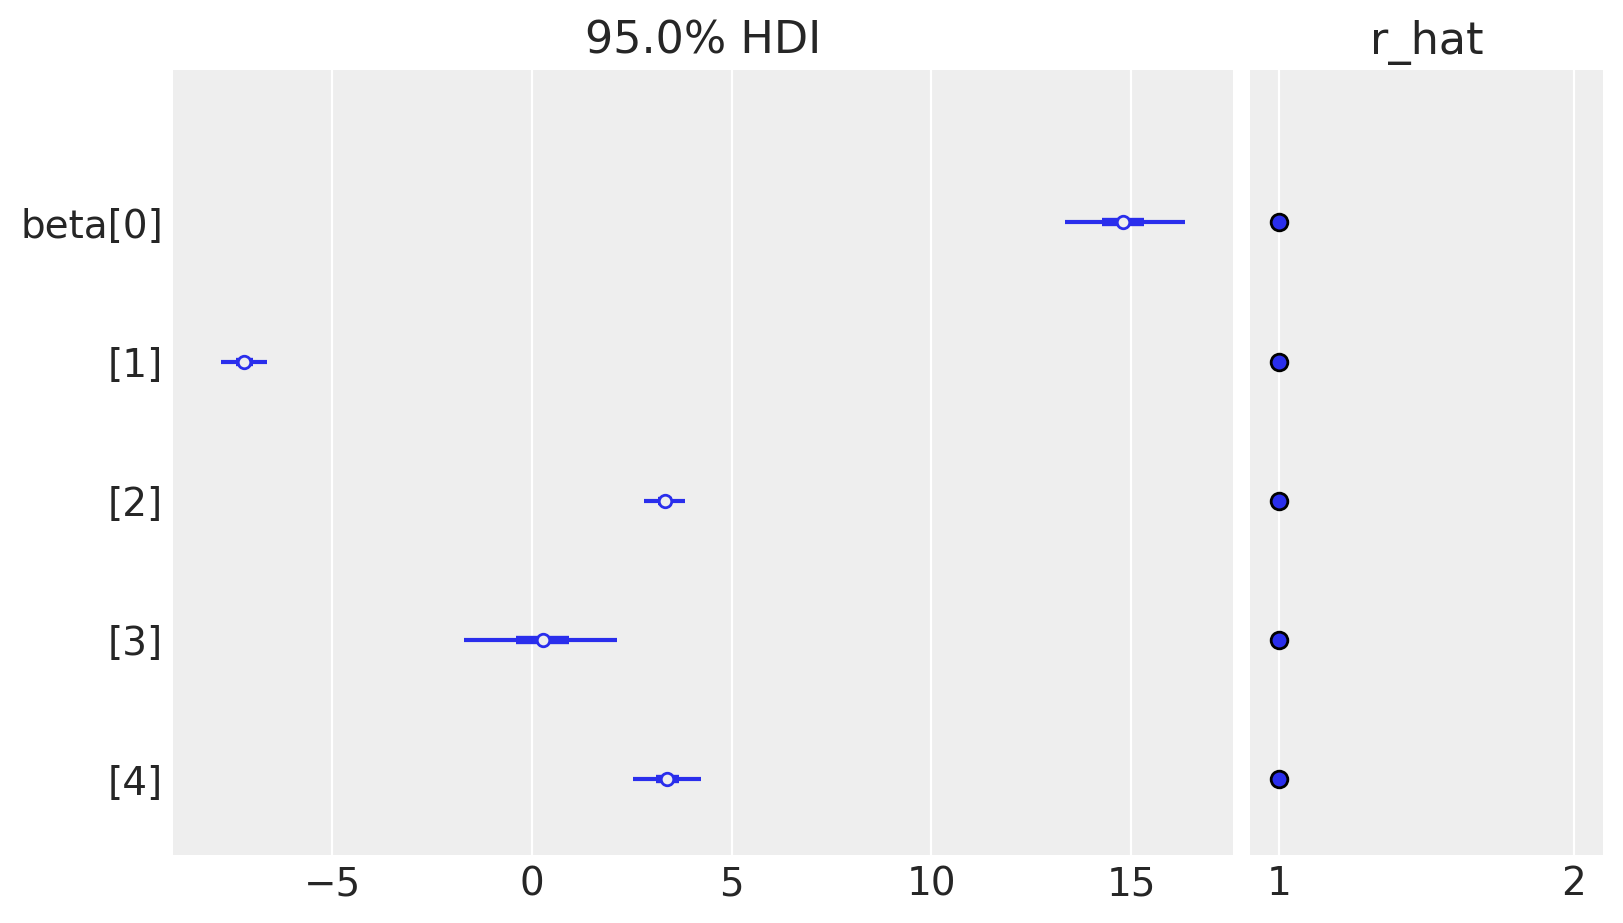

In [10]:
az.plot_forest(idata_posterior, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

In [11]:
az.summary(idata_posterior, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,145.493,0.777,144.087,147.048
beta[0],14.797,0.777,13.357,16.239
beta[1],-7.196,0.300,-7.752,-6.642
beta[2],3.331,0.262,2.849,3.834
beta[3],0.265,0.974,-1.699,1.961
...,...,...,...,...
mu[539],143.608,0.616,142.486,144.789
mu[540],161.435,0.372,160.754,162.146
mu[541],159.575,0.577,158.488,160.651
mu[542],73.954,0.670,72.719,75.224


### Comparison w/ `statsmodels` linear regression

In [12]:
import statsmodels.api as sm

ols_x = data.drop(columns='height')
ols_y = data['height']

ols_x = pipeline.transform(ols_x)

ols_x = sm.add_constant(ols_x)
ols_model = sm.OLS(ols_y, ols_x).fit() 
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3829.
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        23:31:22   Log-Likelihood:                -1597.2
No. Observations:                 544   AIC:                             3206.
Df Residuals:                     538   BIC:                             3232.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.5658      0.779    186.842      0.0

In [38]:
import plotly_express as px

ols_predictions = ols_model.predict(ols_x)
temp = data.copy()
temp['sex'] = temp['male'].apply(lambda x: 'male' if x else 'female')
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights (OLS)"] = ols_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights (OLS)",
    facet_col='sex',
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction (OLS)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0], row='all', col='all', exclude_empty_subplots=True)
fig


---

## Target Variable

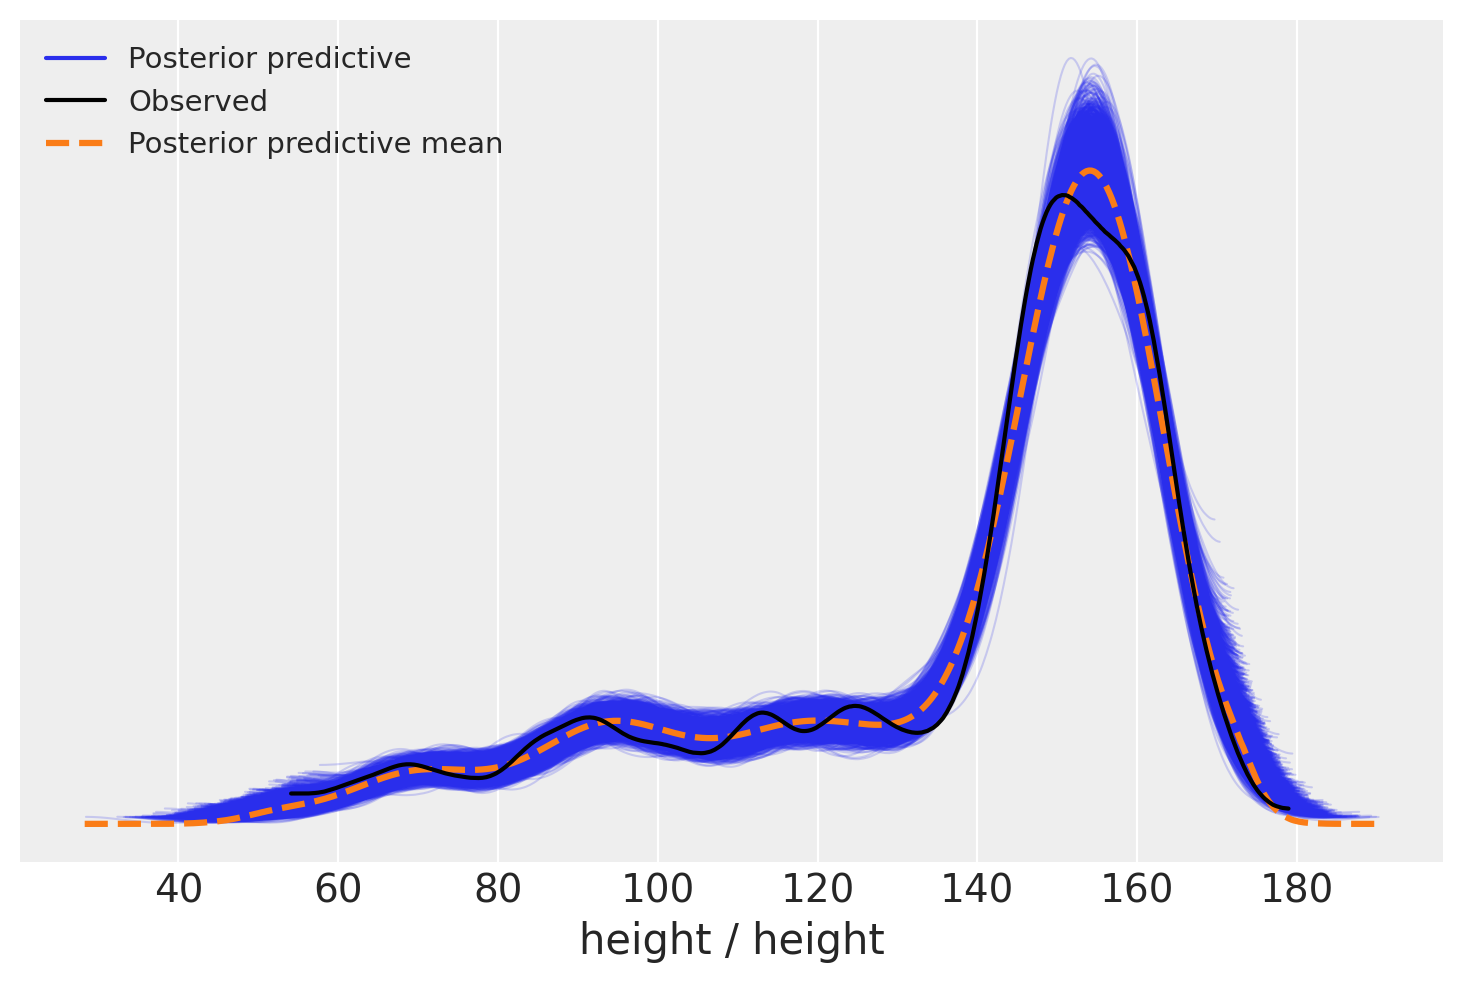

In [33]:
az.plot_ppc(idata_predictive);

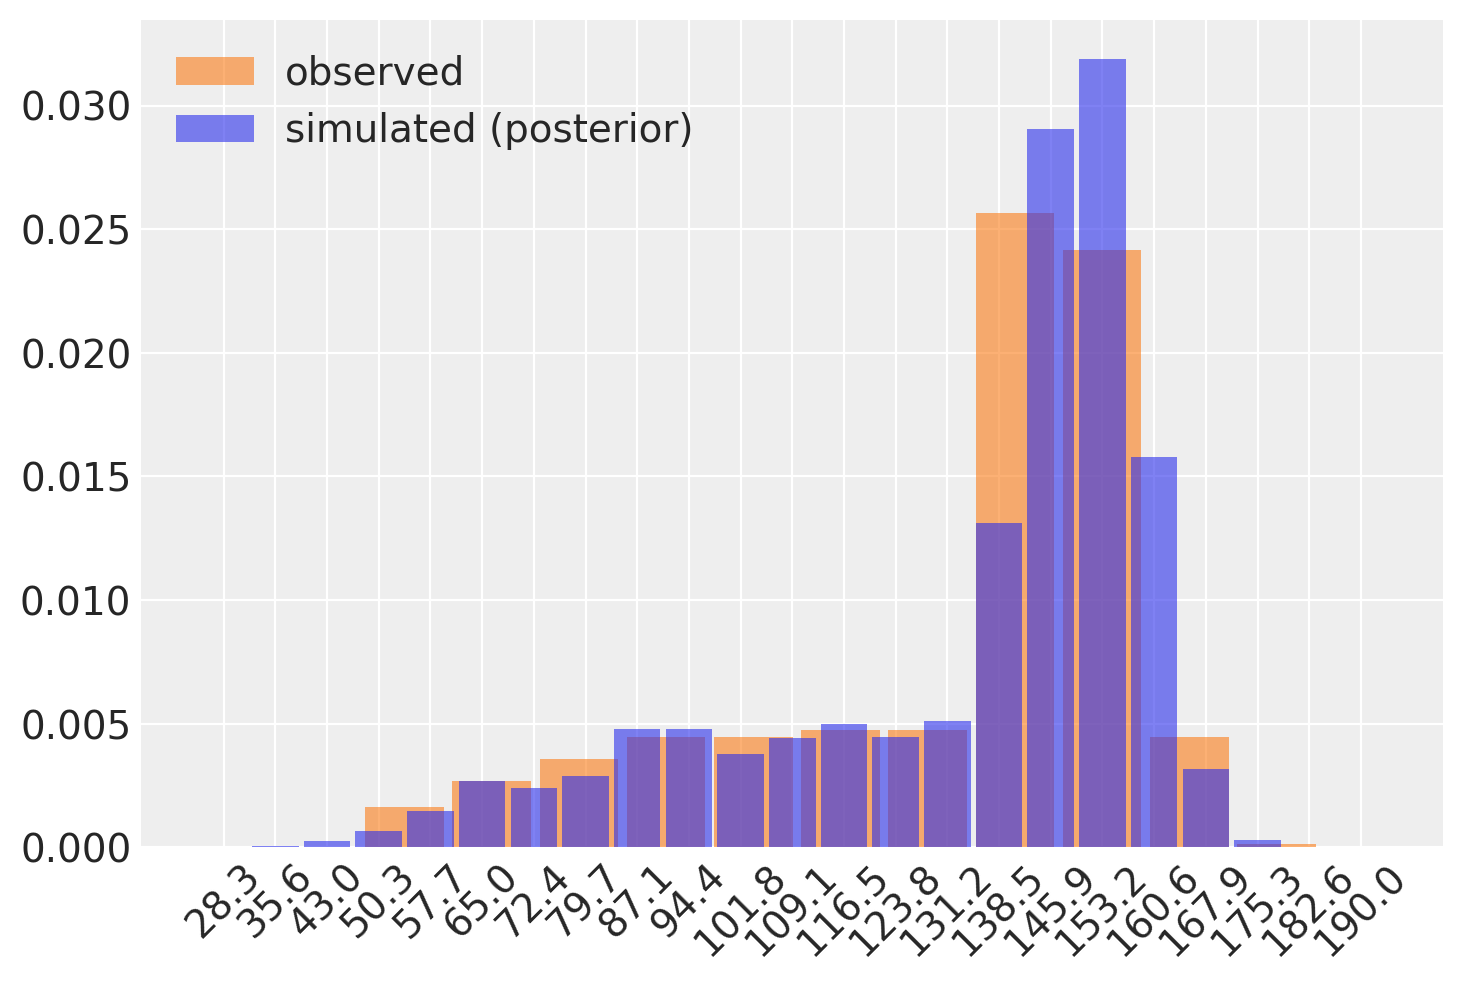

In [15]:
az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_predictive.posterior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (posterior)",
)
plt.xticks(rotation=45);

In [16]:
prediction_simulations = ph.get_posterior_samples(idata_predictive)
prediction_simulations.shape

(544, 4000)

In [17]:
print(prediction_simulations.min().min())
print(prediction_simulations.max().max())

28.27241191259886
190.36783770360177


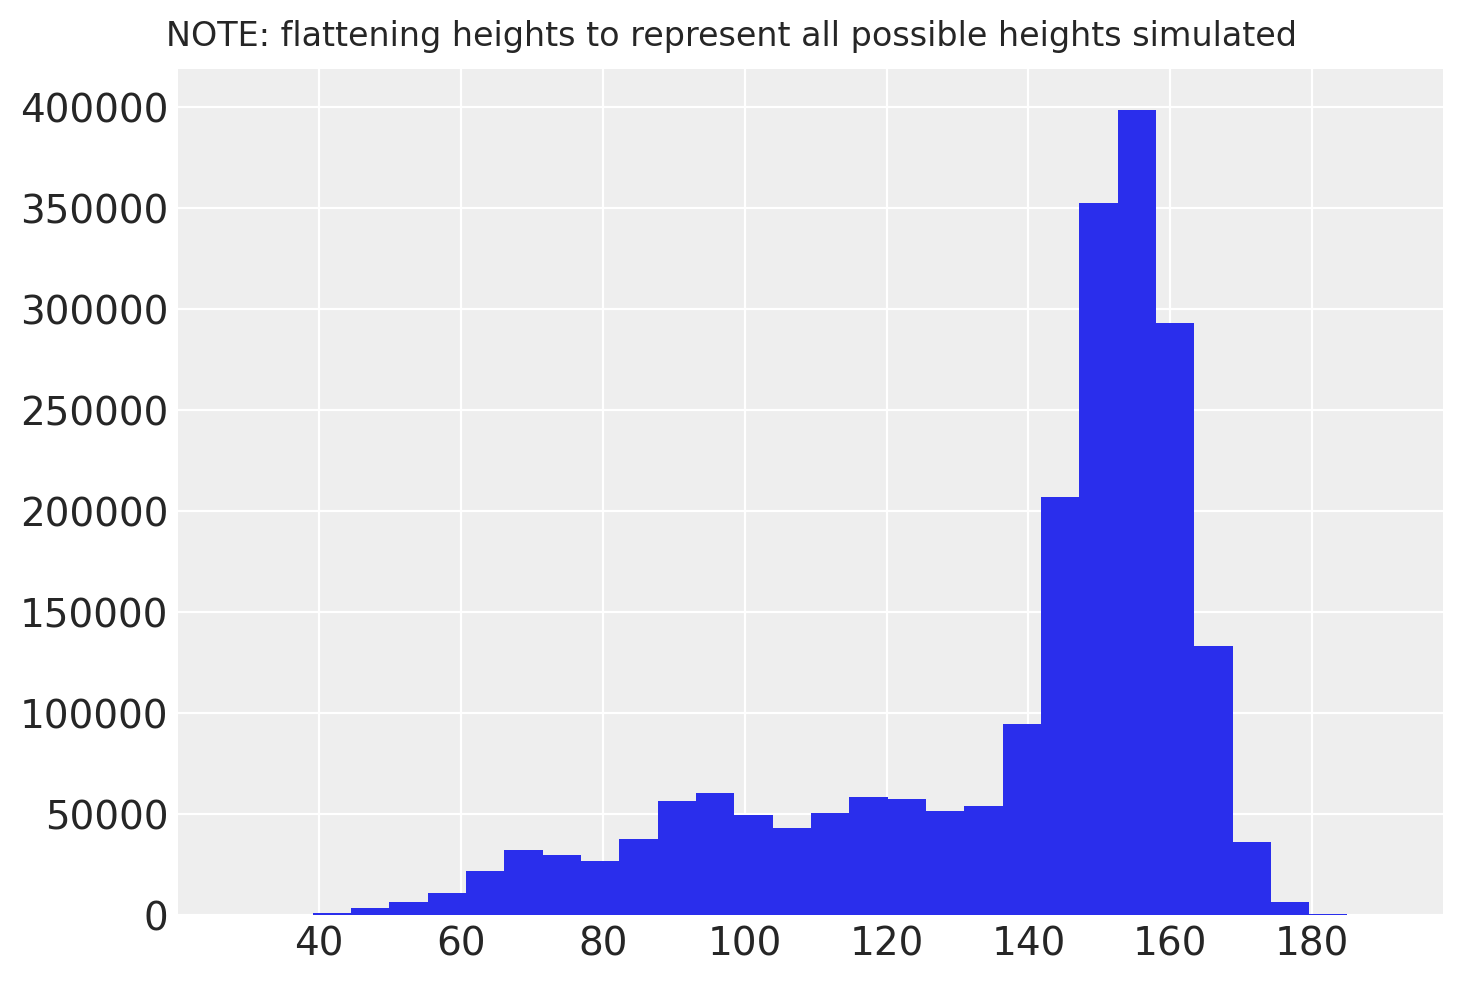

In [18]:
plt.hist(prediction_simulations.flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

Each height is associated with `4000` simulated values. Now get the median/expected value and plot histogram of median values just to see the difference.

In [19]:
print(np.median(prediction_simulations, axis=1).min())
print(np.median(prediction_simulations, axis=1).max())

48.976834001141
173.18316562743252


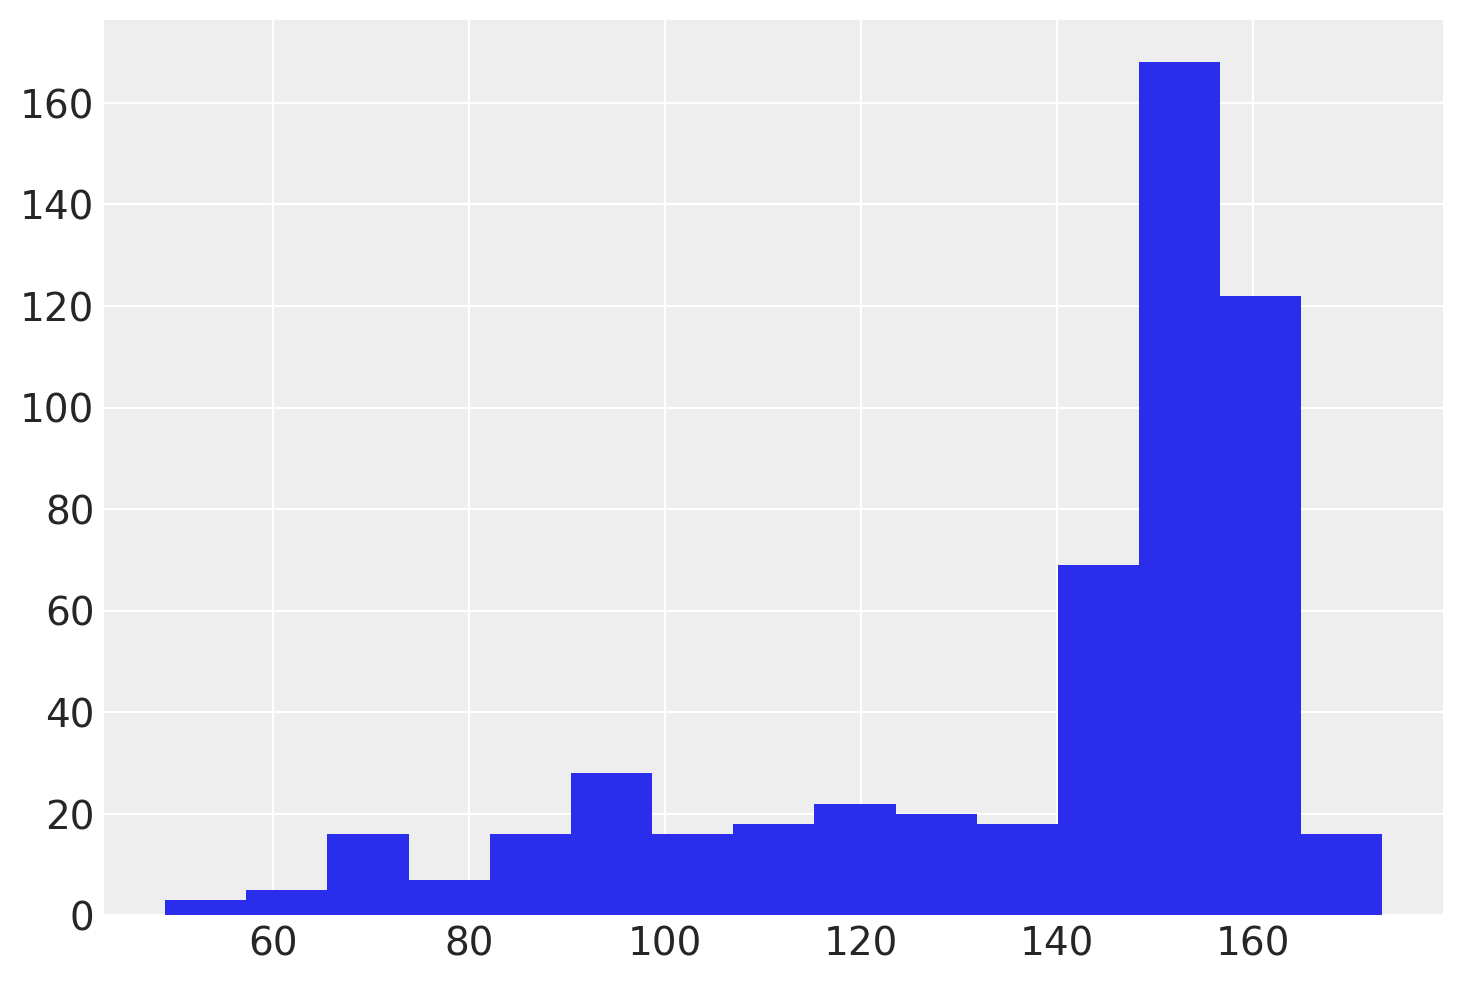

In [20]:
plt.hist(np.median(prediction_simulations, axis=1), bins=15);

In [21]:
az.summary(idata_posterior, kind="stats")

,mean,sd,hdi_3%,hdi_97%
a,145.493,0.777,144.087,147.048
beta[0],14.797,0.777,13.357,16.239
beta[1],-7.196,0.300,-7.752,-6.642
beta[2],3.331,0.262,2.849,3.834
beta[3],0.265,0.974,-1.699,1.961
...,...,...,...,...
mu[539],143.608,0.616,142.486,144.789
mu[540],161.435,0.372,160.754,162.146
mu[541],159.575,0.577,158.488,160.651
mu[542],73.954,0.670,72.719,75.224


In [22]:
az.summary(idata_predictive, kind="stats")

/usr/local/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning:

Selecting first found group: posterior_predictive



,mean,sd,hdi_3%,hdi_97%
height[0],158.462,4.596,150.396,167.609
height[1],146.805,4.475,138.420,155.347
height[2],141.324,4.530,133.220,150.258
height[3],162.124,4.673,153.597,170.974
height[4],150.542,4.613,141.889,158.992
...,...,...,...,...
height[539],143.680,4.707,134.991,152.595
height[540],161.388,4.565,152.479,169.724
height[541],159.635,4.622,151.361,168.678
height[542],73.981,4.573,65.318,82.298


In [23]:
posterior_target_samples = ph.get_posterior_samples(idata_predictive)
posterior_target_point_predictions = np.median(posterior_target_samples, axis=1)
assert posterior_target_samples.shape[0] == len(posterior_target_point_predictions)

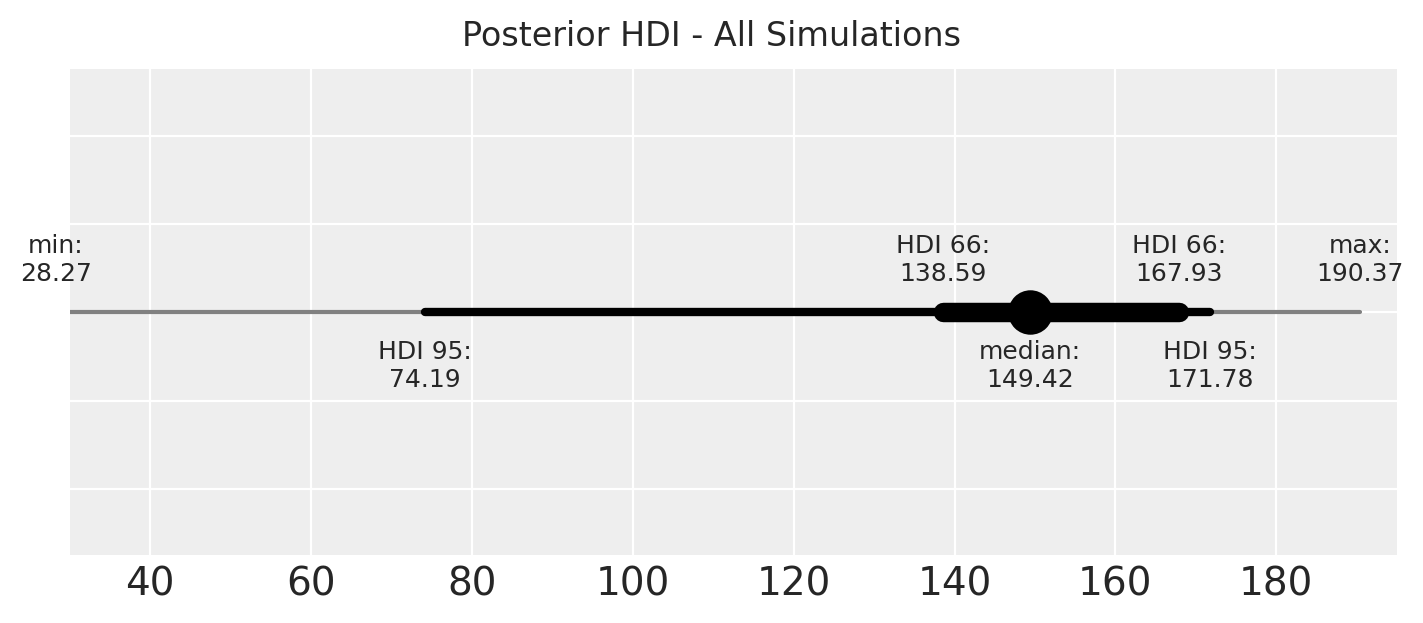

In [24]:
from helpsk.string import format_number

samples_flattened = posterior_target_samples.flatten()

sim_min, sim_median, sim_max = np.quantile(samples_flattened, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(samples_flattened, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(samples_flattened, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
plt.xlim((30, 195))
plt.suptitle("Posterior HDI - All Simulations");

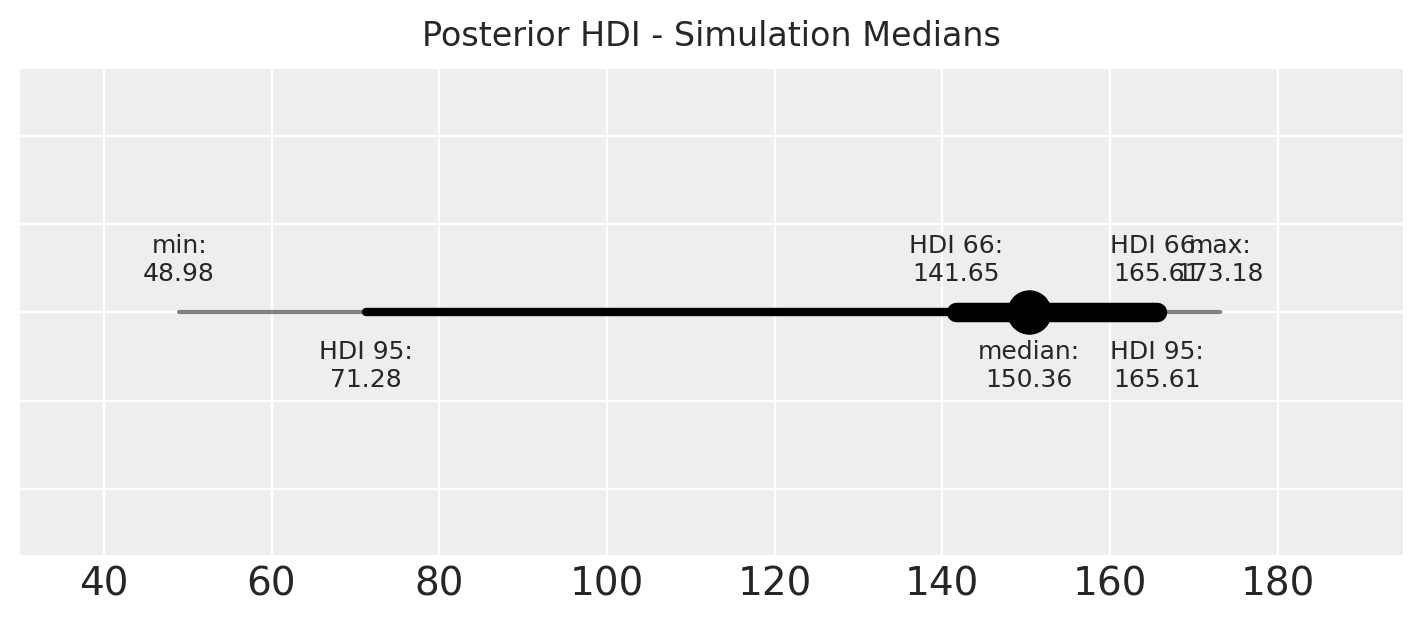

In [25]:
from helpsk.string import format_number

sim_min, sim_median, sim_max = np.quantile(posterior_target_point_predictions, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(posterior_target_point_predictions, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(posterior_target_point_predictions, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
plt.xlim((30, 195))
fig.set_size_inches(w=7, h=3)
plt.suptitle("Posterior HDI - Simulation Medians");

## Actual vs Predicted

In [51]:
import plotly_express as px

temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp['sex'] = temp['male'].apply(lambda x: 'male' if x else 'female')
temp["Predicted Heights"] = posterior_target_point_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights",
    facet_col='sex',
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0], row='all', col='all', exclude_empty_subplots=True)
fig


## Residuals

In [41]:
temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp['sex'] = temp['male'].apply(lambda x: 'male' if x else 'female')
temp["Residuals"] = posterior_target_point_predictions - temp['Actual Heights']

fig = px.histogram(
    temp,
    x="Residuals",
    facet_col='sex',
    title="Residuals (Predicted - Actual)<br><sup>red line is perfect fit</sup>",
)
fig.add_vline(x=0, line_width=3, line_color="red")
fig

In [42]:
fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Residuals",
    facet_col='sex',
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Residual (Predicted - Actual)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)
fig.add_hline(y=0, line_width=3, line_color="red")
fig


---

# New Predictions

In [28]:
new_data = pd.DataFrame(dict(
    weight=[10, 20, 30, 40],
    age=[10, 20, 30, 40],
    male=[1, 0, 0, 0],
))
new_data = pipeline.transform(new_data)
print(new_data)
prediction_sims = ph.posterior_predict(
    model=model_poly,
    idata_posterior=idata_posterior,
    data=new_data
)
prediction_sims

Sampling: [height]


[[-1.74155031  3.03299747 -5.28211767  0.          1.        ]
 [-1.06153925  1.12686558 -1.19621205  1.          0.        ]
 [-0.3815282   0.14556377 -0.05553668  1.          0.        ]
 [ 0.29848286  0.08909202  0.02659244  1.          0.        ]]


array([[ 90.37596192,  83.0494937 ,  83.05592783, ...,  82.2820019 ,
         82.70227935,  83.84514684],
       [116.45009004, 119.53556388, 125.28941559, ..., 114.59676654,
        119.64215193, 117.06917783],
       [143.08351363, 136.25040168, 135.35015197, ..., 136.2790682 ,
        151.18732277, 142.71900262],
       [145.44484718, 142.68150558, 148.20155146, ..., 153.89771685,
        146.61756136, 145.72567413]])

In [29]:
np.median(prediction_sims, axis=1)

array([ 83.73561509, 118.06346788, 138.9184877 , 149.6148019 ])

---

## What is the difference in the **expected** or **predicted** height for any given set of individuals between men and women at age 20 across all weights from 30 to 60?

In [66]:
sim_weights = np.repeat(np.arange(30, 61), 2)
print(sim_weights)


[30 30 31 31 32 32 33 33 34 34 35 35 36 36 37 37 38 38 39 39 40 40 41 41
 42 42 43 43 44 44 45 45 46 46 47 47 48 48 49 49 50 50 51 51 52 52 53 53
 54 54 55 55 56 56 57 57 58 58 59 59 60 60]


In [74]:
sim_age = np.repeat(20, len(sim_weights))
assert len(sim_age) == len(sim_weights)
print(sim_age)

[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20
 20 20 20 20 20 20 20 20 20 20 20 20 20 20]


In [73]:
sim_sex = np.tile(np.arange(0, 2), int(len(sim_weights) / 2))
assert len(sim_sex) == len(sim_weights)
print(sim_sex)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [86]:
new_data = pd.DataFrame(dict(
    weight=sim_weights,
    age=sim_age,
    male=sim_sex,
))
new_data.head()

,weight,age,male
0,30,20,0
1,30,20,1
2,31,20,0
3,31,20,1
4,32,20,0


In [87]:
new_data = pipeline.transform(new_data)
prediction_sims = ph.posterior_predict(
    model=model_poly,
    idata_posterior=idata_posterior,
    data=new_data,
)
assert prediction_sims.shape[0] == len(sim_weights);

Sampling: [height]


### Looks at results only for age 30 (i.e. first and second row, first row is female, second is male)

(array([   3.,   19.,  116.,  398.,  881., 1137.,  906.,  415.,  103.,
          22.]),
 array([123.33081623, 126.77428615, 130.21775607, 133.66122599,
        137.10469591, 140.54816583, 143.99163575, 147.43510567,
        150.87857559, 154.32204551, 157.76551543]),
 <BarContainer object of 10 artists>)

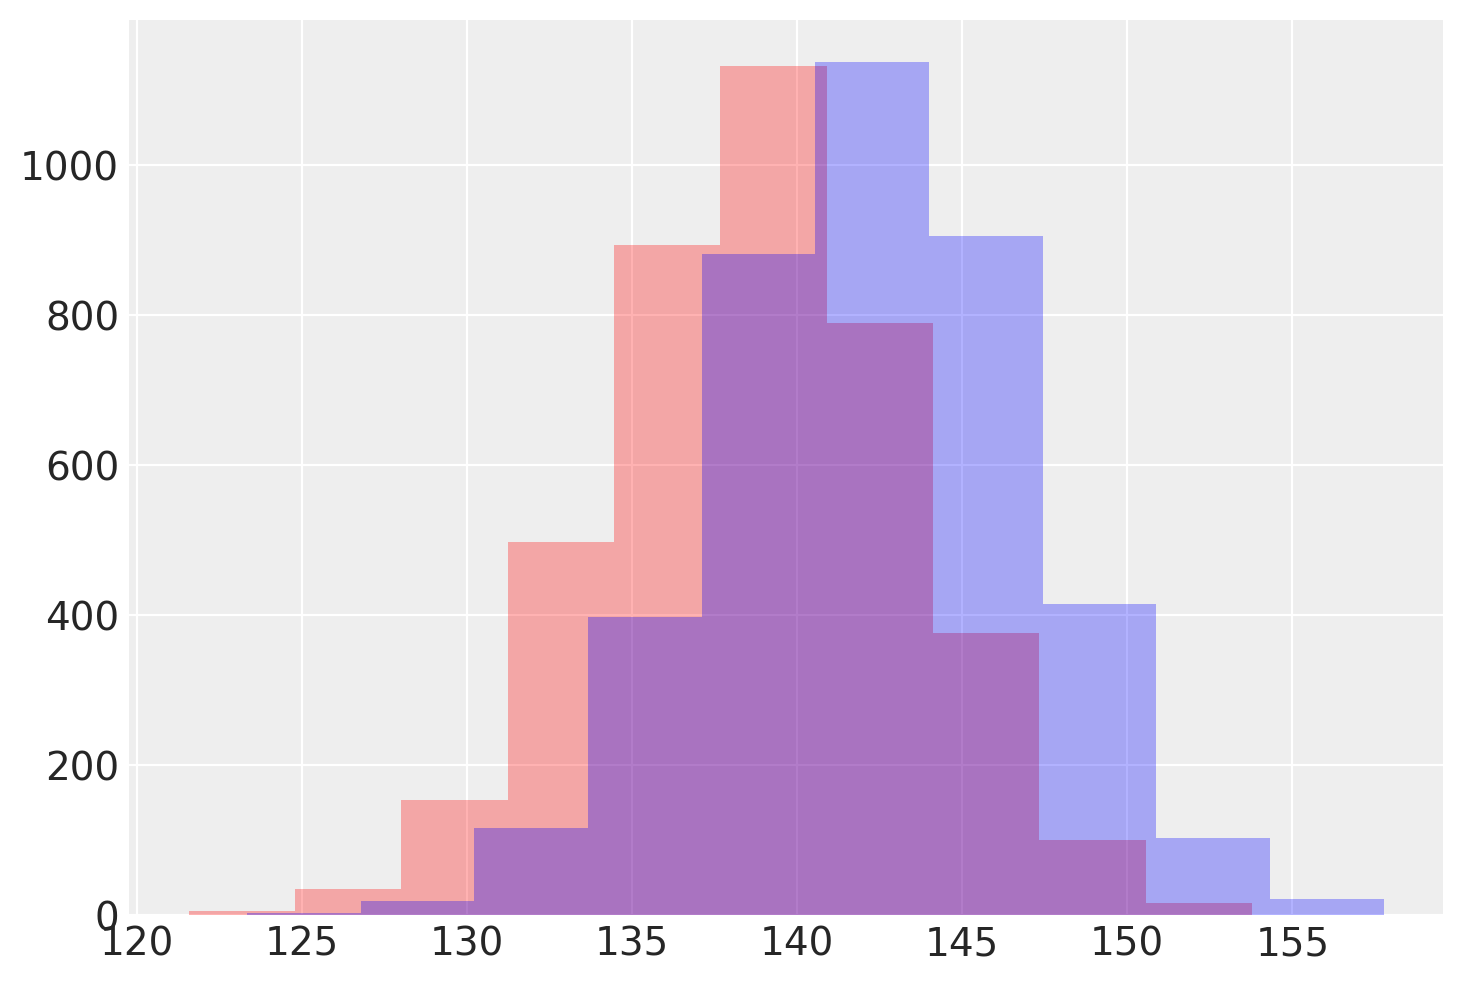

In [99]:
plt.hist(prediction_sims[0, :], color='red', alpha=0.3)
plt.hist(prediction_sims[1, :], color='blue', alpha=0.3);

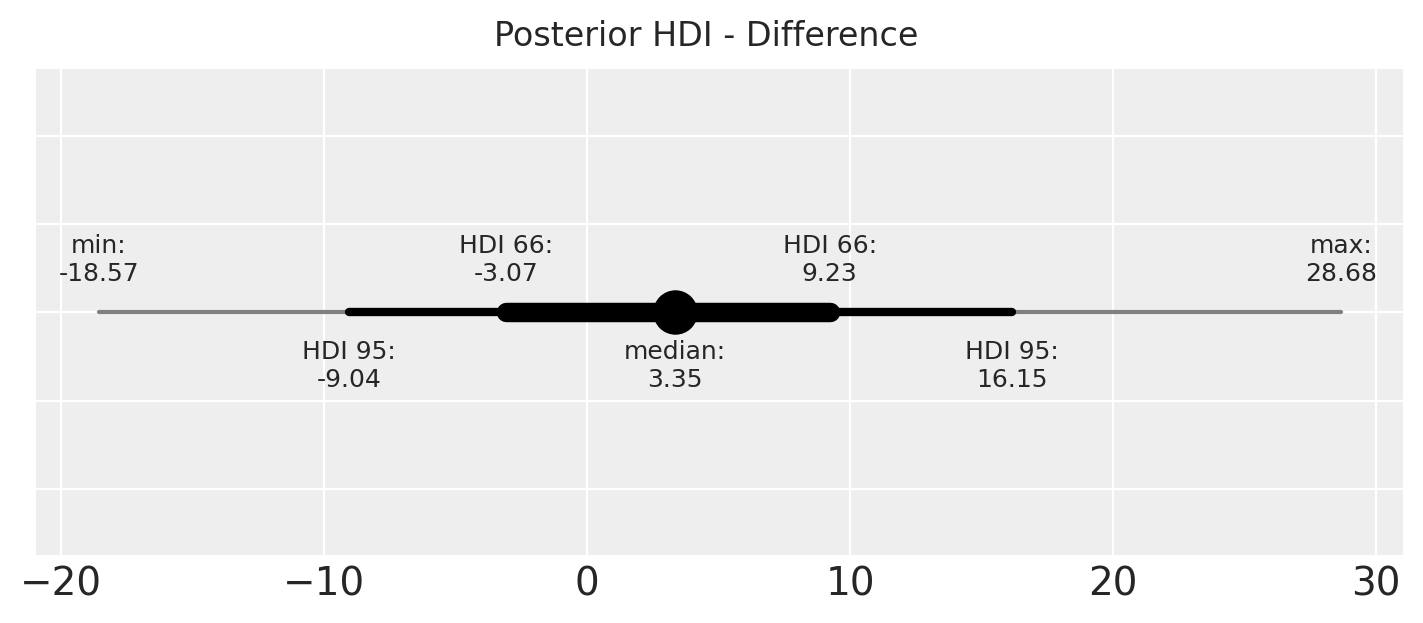

In [103]:
from helpsk.string import format_number

# male - female sims at weight 30
samples = prediction_sims[1, :] - prediction_sims[0, :]

sim_min, sim_median, sim_max = np.quantile(samples, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(samples, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(samples, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
#plt.xlim((30, 195))
plt.suptitle("Posterior HDI - Difference ");

In [104]:
print(np.median(prediction_sims[0, :]))
print(np.median(prediction_sims[1, :]))
print(np.median(prediction_sims[1, :] - prediction_sims[0, :]))

138.84858202980698
142.26742715278635
3.345138546578184


On average the expected height of a male and female at age 20 with a weight of `30` is `3.35`, but can likely (95% hdi) range anywhere from the male being 9cm (3.5 inches) shorter to 16 (6.3 inches) taller, with the average male being 142cm. Remember we are dealing with the low end of weight

In [111]:
np.mean((prediction_sims[1, :] - prediction_sims[0, :]) > 0)

0.7065

70% of our simulations are greater than 1 i.e. There is a 70% probability that any given male will be taller than any given female, weighting each weighing `30kg`, given the assumptions of this model.

---